# Myers-Briggs Personality Prediction

#### by Weston Shuken

---

## Overview

The purpose of this project is to use machine learning algorithms to precict the personality type of a person given their written text in English. The personality type predictions are based on the Myers-Briggs Type Indicator (MBTI) test as the target variable. The features or predictor variables are comments and posts from userson [PersonalityCafe](https://www.personalitycafe.com/). These posts and comments come from users who have explicitley labeled their MBTI personality on their profile. 

The Myers-Briggs test is a very popular test that ask users approximately 90 questions about their behavior and assigns the user a type of personality based on this assessment. This test takes around 20-30 for someone to complete. 

There are 16 different personality types using a combination of 8 overall traits. See below:

    Introversion (I) vs Extroversion (E)
    Intuition (N) vs Sensing (S)
    Thinking (T) vs Feeling (F)
    Judging (J) vs Perceiving (P)
    

## Exploratory Data Analysis

In [2]:
# Imports for EDA, Cleaning, Plotting & Modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag

from scipy.stats import binom

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from mbti import run_models, preprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Random Seed for everything
SEED = 53188535

In [ ]:
# Loading the Data
cafe_df = pd.read_csv('data/mbti_1.csv')

In [ ]:
cafe_df

In [ ]:
cafe_df.info()

In [ ]:
cafe_df['type'].value_counts(normalize=True)

In [ ]:
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(20,8))
plt.bar(cafe_df['type'].value_counts(normalize=True).index, cafe_df['type'].value_counts(normalize=True).values*100)
plt.title('Class Imbalance by percentage')
plt.ylabel('%');

In [ ]:
# looking at a random posts
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_df['posts'].iloc[rint][:1000])

## BE CAREFUL... Reddit posts can sometimes be quite rude...

#### Takeaways from seeing the dataset:

- The classes are quite imbalanced, which can bias the model to choosing one class over the other just given class weight.
- There is a lot of cleaning to do with the text (lowercase, remove urls, remove symbols/punctuation, lemmitization, etc.)
- There are definitely incorrect spellings of words and acroynms like `lol` & `btw`
- The posts might include the personality type in them, which could be considered `data leakage`.

### Cleaning & Tokenizing

In [ ]:
cafe_clean = cafe_df.copy()

In [ ]:
# Lowercase y variables
cafe_clean['type'] = cafe_clean.type.str.lower()

# Creating list of the targets
mbti_lst = list(set(cafe_clean['type'].values))

# Lowercase X varaible onto a new column
cafe_clean['clean_posts'] = cafe_clean['posts'].str.lower()

In [ ]:
# Bringing in the prepreoccess class from mbti.py
# This class provides functions to clean and tokenize our text data
prepro = preprocess()

In [ ]:
plt.figure(figsize=(10,5))
for mbti in mbti_lst:
    plt.bar(str(mbti), len(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index))
    plt.title('Data Leakage \n target within predictors')
    plt.ylabel('counts')
    # print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

In [ ]:
# Remove the target names in the actual posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.replace_mbti(x))

In [ ]:
cafe_clean

In [ ]:
for mbti in mbti_lst:
    print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

In [ ]:
# The posts contain multiple posts seperated by 3 pipes '|||' w/ no spaces between. 
# This function will remove pipes and replace with a space.
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.pipe_remove(x))

# This funciton will remove URLs in the posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.url_remove(x))

# This function will remove punctuation (dependent on what is passed in). This has `/``, `_`, `:` 
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.punc_remove(x))

# Removes all characters that are not American Standard Code for Information Interchange
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.remove_symbols(x))

# Fixes all spelling errors
# cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.spelling(x))

In [ ]:
# This will create a column of cleaned words that have been tokenized.
pattern = r"(?u)\b\w\w+\b" # words with more than 2 letters
tokenizer = RegexpTokenizer(pattern) # instantiate tokenizer
cafe_clean['post_tokens'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize) # Tokenize to new column

In [ ]:
# Removing any remaining numeric digits
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_dig_token(x))

# Removing stopwords
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_stopwords(x))

# Lemmatizing the words with POS tagging
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.lemmend_pos(x, pos=False)) # If true, takes a while (3mins)

In [ ]:
# Joining the tokens together into one long string
cafe_clean['joined_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.join_tokens(x)) # Creating new column

In [ ]:
# showing what characters are in the cleaned text vs. the pre-cleaned text
clean_corpus = ' '.join(cafe_clean['joined_tokens'])
print(f'CLEANED: {"".join(sorted(set(clean_corpus.lower())))}')
print('-'*25)
print('-'*25)


corpus = ' '.join(cafe_df['posts'])
print(f'PRE-CLEANED: {"".join(sorted(set(corpus.lower())))}')

In [ ]:
cafe_clean.head(5)

---

In [ ]:
total_words = cafe_clean['posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

clean_words = cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()
print(f'The cleaned tokens tally up to {clean_words} total words')

print('-'*20)

ave_post = cafe_clean['posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

ave_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).mean()
print(f'Each feature in cleaned has on average {round(ave_cleaned)} words')

print('-'*20)

med_post = cafe_clean['posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

med_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).median()
print(f'Each feature has a median of {round(med_cleaned)} words')

print('-'*20)

min_post = cafe_clean['posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

min_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).min()
print(f'The minimum post in cleaned is {round(min_cleaned)} words')

print('-'*20)

max_post = cafe_clean['posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')

max_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).max()
print(f'The minimum post in cleaned is {round(max_cleaned)} words')

print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(cafe_clean['post_tokens'].apply(lambda x: len(x)), label='cleaned', alpha=.5, bins=100)
plt.hist(cafe_clean['posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.axvline(ave_cleaned, color='r', linestyle='dashed', linewidth=3, label='cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [ ]:
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_clean['posts'].iloc[rint][:2000])
print('-'*25)
print(cafe_clean['joined_tokens'].iloc[rint][:2000])

#### Takeaways:
- A lot of words were reduced or eliminated that did not provide any use.
- The dataset still has posts with very little words. Might need to drop these.
- The lemmitization did not work well on some verbs and the `MBTI` replacement often is followed by an `s`.


In [ ]:
# Adding Binary Targets
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])

In [ ]:
print(cafe_clean['i/e'].value_counts(normalize=True))
print(cafe_clean['n/s'].value_counts(normalize=True))
print(cafe_clean['t/f'].value_counts(normalize=True))
print(cafe_clean['p/j'].value_counts(normalize=True))

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Weights Between Binary Classes')
plt.ylabel('counts')
for column in cafe_clean.columns[-4:]:
    plt.bar(cafe_clean[column].value_counts().index, cafe_clean[column].value_counts().values, label=column)

plt.legend()
plt.show();

### Sentiment Analysis w/ VADER

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [ ]:
sid.polarity_scores(cafe_clean.loc[2,'joined_tokens'])

In [ ]:
cafe_clean['sentiment'] = cafe_clean['joined_tokens'].apply(lambda x: sid.polarity_scores(x))

In [ ]:
cafe_clean['sentiment_total'] = cafe_clean['sentiment'].apply(lambda x: x['compound'])

In [ ]:
cafe_clean['sentiment_score'] = cafe_clean['sentiment_total'].apply(lambda x: '+' if x >= 0 else '-')

In [ ]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.sentiment_total.mean()}')
    scores_dict.update({mbti: data.sentiment_total.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height);


In [ ]:
scores_dict = {}
for mbti in ['t', 'f']:
    data = cafe_clean[cafe_clean['t/f'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.sentiment_total.mean()}')
    scores_dict.update({mbti: data.sentiment_total.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(10,5))
plt.bar(x, height);

In [ ]:
cafe_clean['polarity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
cafe_clean['subjectivity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['polarity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

In [ ]:
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['subjectivity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

In [ ]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.polarity.mean()}')
    scores_dict.update({mbti: data.polarity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height);

In [ ]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.subjectivity.mean()}')
    scores_dict.update({mbti: data.subjectivity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height);

In [ ]:
scores_dict = {}
for mbti in ['t', 'f']:
    data = cafe_clean[cafe_clean['t/f'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.polarity.mean()}')
    scores_dict.update({mbti: data.polarity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(10,5))
plt.bar(x, height);

In [ ]:
scores_dict = {}
for mbti in ['t', 'f']:
    data = cafe_clean[cafe_clean['t/f'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.subjectivity.mean()}')
    scores_dict.update({mbti: data.subjectivity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(10,5))
plt.bar(x, height);

In [ ]:
# Susan Li
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(cafe_clean['joined_tokens'], 20)
# for word, freq in common_words:
#     print(word, freq)
df_tgrams = pd.DataFrame(common_words, columns = ['Posts' , 'count'])
df_tgrams = df_tgrams.groupby('Posts').sum()['count'].sort_values(ascending=True)
plt.figure(figsize=(15,8))
plt.barh(df_tgrams.index, df_tgrams.values);


In [ ]:
blob = TextBlob(str(cafe_clean['joined_tokens']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
plt.figure(figsize=(15,8))
plt.barh(pos_df.index, pos_df.values);

In [ ]:
cafe_clean.columns

In [ ]:
print(f"Amount of words in corpus: {cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()}")
print(f"Amount of chars in cropus: {cafe_clean['joined_tokens'].apply(lambda x: len(x)).sum()}")
print(f"Average word length:\
 {cafe_clean['joined_tokens'].apply(lambda x: len(x)).sum() / cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()} ")

In [ ]:
# cafe_clean.to_csv('./data/cafe_clean_pos.csv')

## Baseline Modeling

There will be 4 sections of modeling:

1. Multiclass
2. Multiclass balanced classes using undersampling
3. Binary
4. Binary balanced classes using undersampling

In [3]:
cafe_clean = pd.read_csv('./data/cafe_clean.csv')
cafe_clean = cafe_clean.dropna()

In [11]:
# Baseline
baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED, loss="modified_huber"),

                  'LogisticRegression': LogisticRegression(n_jobs=1, C=.001),

                  'NaiveBayes': MultinomialNB(),
               
                  'KNN': KNeighborsClassifier(random_state=SEED),
               
                  'RandomForest': RandomForestClassifier(max_depth=8, random_state=SEED)
               }

In [ ]:
for clf in baseline_models:
    print(baseline_models[clf])

In [13]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [8]:
rm = run_models()

In [ ]:
multiclass_cv = rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=False, SEED=234)
multiclass_cv

In [ ]:
multiclass_tfidf = rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=234)
multiclass_tfidf

In [ ]:
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .4108)
plt.barh(cafe_clean['type'].value_counts(normalize=True).index, cafe_clean['type'].value_counts(normalize=True).values)
plt.xlim(0, 1)

#### Multiclass Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [ ]:
multiclass_rus_cv = rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=False, SEED=234)
multiclass_rus_cv

In [ ]:
multiclass_rus_tfidf = rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=234)
multiclass_rus_tfidf

In [ ]:
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .1143)
plt.barh('class balance', 1/16)
plt.xlim(0, 1)

In [ ]:
multiclass_cv['other'] = 'countvec'
multiclass_tfidf['other'] = 'tfidf'
multiclass_rus_cv['other'] = 'rus_countvec'
multiclass_rus_tfidf['other'] = 'rus_tfidf'


base_mc = pd.concat([multiclass_cv, multiclass_tfidf, multiclass_rus_cv, multiclass_rus_tfidf])
base_mc

### Multiclass Undersampled Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [5]:
bin_targets = ['i/e', 'n/s', 't/f', 'p/j']
bin_targets

['i/e', 'n/s', 't/f', 'p/j']

In [14]:
bin_cv = rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=SEED)
bin_cv

--------------------
i/e, target balance: 
i    0.769562
e    0.230438
Name: i/e, dtype: float64
Vectorizing....  @ Tue Mar  8 10:32:02 2022
Working on SGDClassifier for i/e @ Tue Mar  8 10:32:10 2022
Working on LogisticRegression for i/e @ Tue Mar  8 10:32:11 2022
Working on NaiveBayes for i/e @ Tue Mar  8 10:32:15 2022
Working on RandomForest for i/e @ Tue Mar  8 10:32:15 2022
--------------------
n/s, target balance: 
n    0.861952
s    0.138048
Name: n/s, dtype: float64
Vectorizing....  @ Tue Mar  8 10:32:19 2022
Working on SGDClassifier for n/s @ Tue Mar  8 10:32:28 2022
Working on LogisticRegression for n/s @ Tue Mar  8 10:32:29 2022
Working on NaiveBayes for n/s @ Tue Mar  8 10:32:32 2022
Working on RandomForest for n/s @ Tue Mar  8 10:32:32 2022
--------------------
t/f, target balance: 
f    0.540968
t    0.459032
Name: t/f, dtype: float64
Vectorizing....  @ Tue Mar  8 10:32:36 2022
Working on SGDClassifier for t/f @ Tue Mar  8 10:32:44 2022
Working on LogisticRegression for t

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7385,0.7303
1,LogisticRegression_i/e,i/e,0.7800,0.7828
2,NaiveBayes_i/e,i/e,0.7339,0.7358
3,RandomForest_i/e,i/e,0.7696,0.7695
4,SGDClassifier_n/s,n/s,0.8074,0.8313
5,LogisticRegression_n/s,n/s,0.8632,0.8621
6,NaiveBayes_n/s,n/s,0.8289,0.8276
7,RandomForest_n/s,n/s,0.8620,0.8621
8,SGDClassifier_t/f,t/f,0.7434,0.7524
9,LogisticRegression_t/f,t/f,0.7731,0.7856


In [15]:
bin_tfidf = rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=SEED)
bin_tfidf

--------------------
i/e, target balance: 
i    0.769562
e    0.230438
Name: i/e, dtype: float64
Vectorizing....  @ Tue Mar  8 10:33:11 2022
Working on SGDClassifier for i/e @ Tue Mar  8 10:33:19 2022
Working on LogisticRegression for i/e @ Tue Mar  8 10:33:20 2022
Working on NaiveBayes for i/e @ Tue Mar  8 10:33:20 2022
Working on RandomForest for i/e @ Tue Mar  8 10:33:20 2022
--------------------
n/s, target balance: 
n    0.861952
s    0.138048
Name: n/s, dtype: float64
Vectorizing....  @ Tue Mar  8 10:33:28 2022
Working on SGDClassifier for n/s @ Tue Mar  8 10:33:37 2022
Working on LogisticRegression for n/s @ Tue Mar  8 10:33:37 2022
Working on NaiveBayes for n/s @ Tue Mar  8 10:33:38 2022
Working on RandomForest for n/s @ Tue Mar  8 10:33:38 2022
--------------------
t/f, target balance: 
f    0.540968
t    0.459032
Name: t/f, dtype: float64
Vectorizing....  @ Tue Mar  8 10:33:46 2022
Working on SGDClassifier for t/f @ Tue Mar  8 10:33:54 2022
Working on LogisticRegression for t

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7473,0.7257
1,LogisticRegression_i/e,i/e,0.7696,0.7695
2,NaiveBayes_i/e,i/e,0.7696,0.7695
3,RandomForest_i/e,i/e,0.7696,0.7695
4,SGDClassifier_n/s,n/s,0.8275,0.8114
5,LogisticRegression_n/s,n/s,0.8620,0.8621
6,NaiveBayes_n/s,n/s,0.8620,0.8621
7,RandomForest_n/s,n/s,0.8620,0.8621
8,SGDClassifier_t/f,t/f,0.7654,0.7690
9,LogisticRegression_t/f,t/f,0.5410,0.5413


Accuracy increase from class balance in i/e is: 0.01
Accuracy increase from class balance in n/s is: -0.01
Accuracy increase from class balance in t/f is: 0.25
Accuracy increase from class balance in p/j is: 0.08


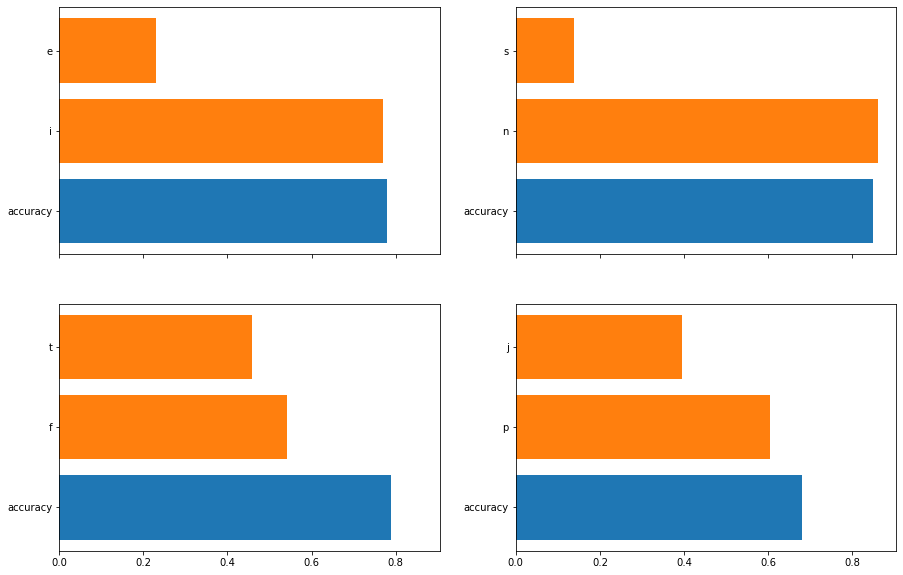

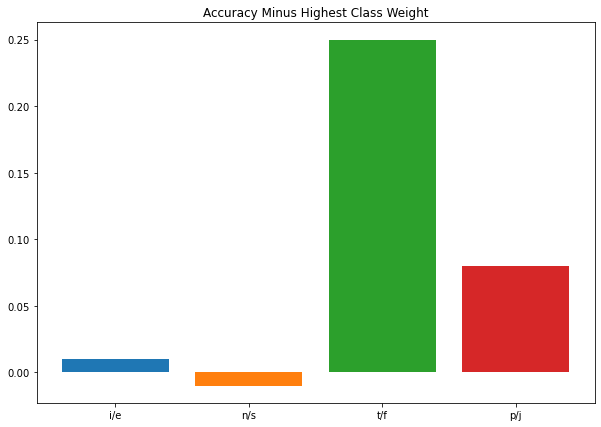

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .78)
axs[0, 0].barh(cafe_clean['i/e'].value_counts(normalize=True).index, cafe_clean['i/e'].value_counts(normalize=True).values)

axs[0,1].barh('accuracy', .85)
axs[0,1].barh(cafe_clean['n/s'].value_counts(normalize=True).index, cafe_clean['n/s'].value_counts(normalize=True).values)

axs[1,0].barh('accuracy', .79)
axs[1,0].barh(cafe_clean['t/f'].value_counts(normalize=True).index, cafe_clean['t/f'].value_counts(normalize=True).values)

axs[1,1].barh('accuracy', .68)
axs[1,1].barh(cafe_clean['p/j'].value_counts(normalize=True).index, cafe_clean['p/j'].value_counts(normalize=True).values)

acc = [.78, .85, .79, .68]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    increase = round(acc[i] - cafe_clean[target].value_counts(normalize=True)[0], 2)
    print(f'Accuracy increase from class balance in {target} is: {increase}')
    plt.bar(target, increase)
plt.show();


In [17]:
bin_rus_cv = rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=SEED)
bin_rus_cv

Train: (array(['e', 'i'], dtype=object), array([1499, 5006]))
Train: (array(['e', 'i'], dtype=object), array([1499, 1499]))
Test: (array(['e', 'i'], dtype=object), array([ 500, 1669]))
Test: (array(['e', 'i'], dtype=object), array([500, 500]))
Vectorizing....  @ Tue Mar  8 10:35:16 2022
Working on SGDClassifier @ Tue Mar  8 10:35:20 2022


ValueError: Found input variables with inconsistent numbers of samples: [1000, 2998]

In [ ]:
bin_rus_tfidf = rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=SEED)
bin_rus_tfidf

In [18]:
# Probability we are seeing these results given a 50/50 class balance

print(f"Pobability of i/e model: {1 - binom.cdf(k=(1499*2)*.68, n=1499*2, p=0.5)}")
print(f"Pobability of n/s model: {1 - binom.cdf(k=(898*2)*.67, n=(898*2), p=0.5)}")
print(f"Pobability of t/f model: {1 - binom.cdf(k=(1499*2)*.80, n=1499*2, p=0.5)}")
print(f"Pobability of p/j model: {1 - binom.cdf(k=(2575*2)*.67, n=2575*2, p=0.5)}")

NameError: name 'binom' is not defined

Accuracy increase from class balance in i/e is: 0.18
Accuracy increase from class balance in n/s is: 0.23
Accuracy increase from class balance in t/f is: 0.3
Accuracy increase from class balance in p/j is: 0.16


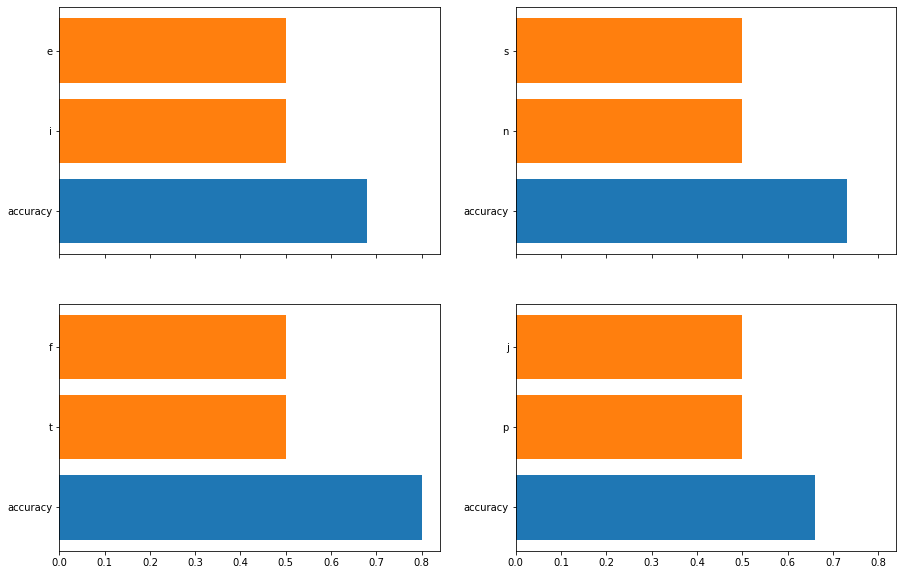

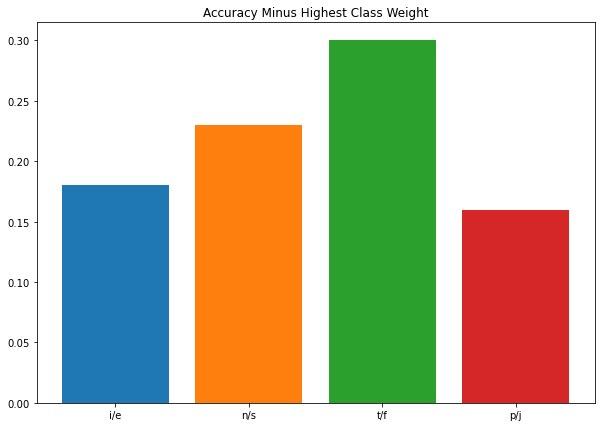

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .68)
axs[0, 0].barh(['i', 'e'], [.5, .5])

axs[0,1].barh('accuracy', .73)
axs[0,1].barh(['n', 's'], [.5, .5])

axs[1,0].barh('accuracy', .8)
axs[1, 0].barh(['t', 'f'], [.5, .5])

axs[1,1].barh('accuracy', .66)
axs[1,1].barh(['p', 'j'], [.5, .5])

acc = [.68, .73, .8, .66]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    print(f'Accuracy increase from class balance in {target} is: {round(acc[i] - .5, 2)}')
    plt.bar(target, round(acc[i] - .5, 2))


---

## Doc2Vec

In [20]:
train_df, test_df = train_test_split(cafe_clean, random_state=SEED)

In [21]:
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [23]:
def tokenize_gens(dataframe):
    for i, post in enumerate(dataframe['joined_tokens']):
        tokens = gensim.utils.simple_preprocess(post)
        yield gensim.models.doc2vec.TaggedDocument(tokens, dataframe.loc[i, 'type'])

train_corpus = list(tokenize_gens(train_df))
test_corpus = list(tokenize_gens(test_df))

In [24]:
# print(train_corpus[0])

TaggedDocument(['structure', 'fine', 'much', 'like', 'clear', 'objective', 'various', 'thing', 'need', 'left', 'device', 'figure', 'accomplish', 'everything', 'set', 'tortoise', 'slow', 'steady', 'thoughtful', 'thick', 'skin', 'long', 'haul', 'losing', 'weight', 'pound', 'longer', 'considered', 'overweight', 'obese', 'love', 'reading', 'writing', 'high', 'school', 'im', 'attending', 'college', 'havent', 'graduated', 'yet', 'vote', 'degree', 'im', 'currently', 'pursuing', 'dont', 'think', 'ive', 'ever', 'romantic', 'dream', 'certainly', 'dont', 'remember', 'unsure', 'teleportation', 'device', 'moving', 'back', 'college', 'ive', 'always', 'gotten', 'good', 'grade', 'ive', 'never', 'felt', 'particularly', 'motivated', 'well', 'unless', 'interested', 'subject', 'material', 'stop', 'worrying', 'plenty', 'time', 'date', 'least', 'time', 'ops', 'post', 'unless', 'something', 'changed', 'last', 'night', 'need', 'information', 'thats', 'ill', 'let', 'loose', 'im', 'small', 'group', 'friend', 'k

In [25]:
# print(test_corpus[0])

TaggedDocument(['note', 'show', 'actual', 'people', 'book', 'thing', 'know', 'sure', 'laura', 'least', 'thats', 'official', 'typology', 'im', 'sure', 'bump', 'mom', 'dad', 'curious', 'different', 'type', 'character', 'favorite', 'book', 'series', 'growing', 'guess', 'meg', 'charles', 'wallace', 'according', 'somewhere', 'calvin', 'sheee', 'eye', 'like', 'piece', 'really', 'good', 'boyfriend', 'mean', 'gave', 'ex', 'kind', 'slack', 'cheat', 'im', 'little', 'concerned', 'reading', 'comment', 'hope', 'youre', 'like', 'gee', 'like', 'everyones', 'critic', 'day', 'worldzmine', 'meant', 'tiptoeing', 'around', 'emotion', 'detriment', 'brain', 'really', 'control', 'situation', 'im', 'fine', 'ill', 'able', 'handle', 'nature', 'helped', 'solve', 'lot', 'big', 'problem', 'made', 'goal', 'sweet', 'used', 'care', 'emotion', 'kind', 'like', 'neh', 'lol', 'tbh', 'think', 'im', 'fine', 'friend', 'helped', 'see', 'perspective', 'though', 'wasnt', 'like', 'friend', 'mine', 'dont', 'know', 'ive', 'let', 

In [26]:
model = gensim.models.doc2vec.Doc2Vec(dm=1, 
                                    vector_size=50, 
                                    min_count=2, 
                                    epochs=40)

In [27]:
model.build_vocab(train_corpus)

In [28]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [29]:
vector = model.infer_vector(['unaware', 'people', 'dont', 'confidence', 'often', 'picture'])
print(vector)

[-0.2947806  -0.12501413 -0.2461907  -0.09921438  0.06169951 -0.21615121
 -0.19722773 -0.29825422 -0.13187549  0.03435902  0.02612853  0.08145522
 -0.44263202 -0.5783993   0.14566088  0.24845244  0.00919266 -0.45479417
  0.29933092 -0.30836245 -0.14739695 -0.07917648  0.24397802  0.3170978
  0.24079102 -0.50799304 -0.3567287   0.2946496  -0.49088126 -0.047347
  0.28229013 -0.03176434  0.14008081  0.03943851 -0.02133674  0.03778005
  0.17460719  0.19680253 -0.32963213  0.03153898  0.19124272 -0.3413413
 -0.25493652  0.17522188  0.28739083  0.13069081  0.43740502  0.5366906
  0.36247182  0.8022144 ]


In [37]:
def vector_for_learning(model, posts):
    targets, feature_vectors = zip(*[(doc.tags, model.infer_vector(doc.words)) for doc in posts])
    return targets, feature_vectors

In [80]:
df = pd.read_csv('./data/testing_df.csv')
rint = np.random.randint(0, len(df))

print(rint)
print(df['posts'].iloc[rint])
df['type'].iloc[rint]

1023
'((Lovin' the new avatar by the way))  xNFP  TMLT be lonely|||I think what my INFJ friend most enjoys about me is her inability to figure me out or predict my actions.  The other day we had a funny conversation that went something like this:  Her: How is...|||(awkwardly replying to this long dead but extremely accurate post)  Well, I can't say it's not true, but, I will say that this is a list of traits that only occur in small ways. Also, ENFPs have a...|||okay, more questions:   how many friends do you have? how many are close friends? are you satisfied with these numbers? why/why not? tell me what your best friend is like. what are his/her...|||Story of my life XD  From a lot of discussion with my friend who's well-versed in MBTI, I've decided that I'm an ENFP, but my enneagram (3w2) can confuse people into thinking otherwise. Also, I was...|||Time: I like to wake up extremely early, sometimes 4:30 or 5, during the school year, because that's when I can be most productive. Howe

'enfp'

In [82]:
df['joined_tokens'].iloc[1023]

'lovin new avatar way xnfp tmlt lonely think friend enjoys inability figure predict action day funny conversation went something like awkwardly replying long dead extremely accurate post well cant say true say list trait occur small way also okay question many friend many close friend satisfied number tell best friend like story life xd lot discussion friend who well versed mbti ive decided im enneagram confuse people thinking otherwise also time like wake extremely early sometimes school year thats productive however evening perhaps favorite time xd would good tactic though enjoy drawing rarely get enough time purely creative thing volunteer lot passion mine improve said would continue remaining possibility direct method imagining something roundabout nature xd nice lively childhood type perpetrator interrogate discover done ask anything detective actually know dezir started wanted try say doctor enter sanctum reason im feeling type least likely believe ghost fascinating idea im going

In [47]:
# Can take a few minutes
y_train, X_train = vector_for_learning(model, train_corpus)
y_test, X_test = vector_for_learning(model, test_corpus)

In [49]:
clf = SGDClassifier(class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.25311203319502074


In [50]:
logreg = LogisticRegression(n_jobs=1, C=.0001, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.3148916551406178


In [51]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=25)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

Testing accuracy: 0.32918395573997233


---

## Model Tuning

In [ ]:
cafe_clean = pd.read_csv('./data/cafe_clean.csv')

In [ ]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(class_weight='balanced', random_state=SEED, loss="modified_huber"))
])

In [ ]:
for target in bin_targets:
    X = cafe_clean['joined_tokens']
    y = cafe_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)

    print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean[target].unique()))

    fig, ax = plt.subplots(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
    plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
    plt.grid(False);
    

---

### i/e

In [ ]:
cafe_clean['i/e'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'s': .77, 'n': .23}, random_state=SEED,  loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['i/e']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['i/e'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### n/s

In [ ]:
cafe_clean['n/s'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'s': .90, 'n': .10}, random_state=SEED,  loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['n/s']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['n/s'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### t/f

In [ ]:
cafe_clean['t/f'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED,  loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### p/j

In [ ]:
cafe_clean['p/j'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2), min_df=50)),
                ('clf', SGDClassifier(class_weight={'p': .40, 'j': .60}, random_state=SEED,  loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['p/j']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['p/j'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

## Final Model

In [ ]:
# cafe_clean = pd.read_csv('./data/cafe_clean.csv')
# cafe_clean.dropna(inplace=True)

              precision    recall  f1-score   support

           f       0.79      0.83      0.81      1152
           t       0.80      0.75      0.78      1017

    accuracy                           0.80      2169
   macro avg       0.80      0.79      0.80      2169
weighted avg       0.80      0.80      0.80      2169



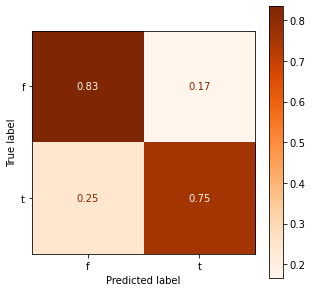

In [4]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2), min_df=50)),
                ('clf', LogisticRegression(class_weight={'f': .45, 't': .55}))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true', cmap='Oranges')
plt.grid(False);

              precision    recall  f1-score   support

           f       0.80      0.79      0.80      1152
           t       0.77      0.78      0.77      1017

    accuracy                           0.79      2169
   macro avg       0.79      0.79      0.79      2169
weighted avg       0.79      0.79      0.79      2169



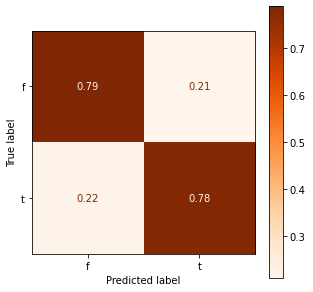

In [83]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2), min_df=50)),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED, loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true', cmap='Oranges')
plt.grid(False);

In [91]:
cafe_clean

,Unnamed: 0,type,posts,clean_posts,post_tokens,joined_tokens,i/e,n/s,t/f,p/j
0,0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top te...,"['moment', 'sportscenter', 'top', 'ten', 'play...",moment sportscenter top ten play prank life ch...,i,n,f,j
1,1,entp,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,"['im', 'finding', 'lack', 'post', 'alarming', ...",im finding lack post alarming sex boring posit...,e,n,t,p
2,2,intp,'Good one _____ https://www.youtube.com/wat...,"good one of course, to which i say i kn...","['good', 'one', 'course', 'say', 'know', 'that...",good one course say know thats blessing curse ...,i,n,t,p
3,3,intj,"'Dear INTP, I enjoyed our conversation the o...","dear , i enjoyed our conversation the other ...","['dear', 'enjoyed', 'conversation', 'day', 'es...",dear enjoyed conversation day esoteric gabbing...,i,n,t,j
4,4,entj,'You're fired.|||That's another silly misconce...,youre fired. thats another silly misconcepti...,"['youre', 'fired', 'thats', 'another', 'silly'...",youre fired thats another silly misconception ...,e,n,t,j
...,...,...,...,...,...,...,...,...,...,...
8670,8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp just because i always think of cats as...,"['ixfp', 'always', 'think', 'cat', 'fi', 'doms...",ixfp always think cat fi doms reason especiall...,i,s,f,p
8671,8671,enfp,'So...if this thread already exists someplace ...,so...if this thread already exists someplace e...,"['thread', 'already', 'exists', 'someplace', '...",thread already exists someplace else heck dele...,e,n,f,p
8672,8672,intp,'So many questions when i do these things. I ...,so many questions when i do these things. i w...,"['many', 'question', 'thing', 'would', 'take',...",many question thing would take purple pill pic...,i,n,t,p
8673,8673,infp,'I am very conflicted right now when it comes ...,i am very conflicted right now when it comes t...,"['conflicted', 'right', 'come', 'wanting', 'ch...",conflicted right come wanting child honestly m...,i,n,f,p


In [92]:
testing_df = cafe_clean.iloc[y_test.index]

In [85]:
testing_set = pd.concat([y_test, X_test], axis=1)

In [95]:
t_sample = testing_df[testing_df['t/f'] == 't'].sample(50, replace=False, random_state=SEED)
f_sample = testing_df[testing_df['t/f'] == 'f'].sample(50, replace=False, random_state=SEED)

testingsample_set = pd.concat([t_sample, f_sample], axis=0)

In [96]:
testingsample_set

,Unnamed: 0,type,posts,clean_posts,post_tokens,joined_tokens,i/e,n/s,t/f,p/j
586,586,intp,'I hate it when I talk to someone who should b...,i hate it when i talk to someone who should be...,"['hate', 'talk', 'someone', 'helping', 'like',...",hate talk someone helping like someone licensi...,i,n,t,p
3259,3259,intj,https://www.youtube.com/watch?v=5F6B1U77dgs|||...,my mind works better in the dark. i always ...,"['mind', 'work', 'better', 'dark', 'always', '...",mind work better dark always look forward long...,i,n,t,j
1981,1981,istj,'http://4.bp.blogspot.com/-9QjARWd5a84/T3OXHJJ...,"me too. once im done, im done. we be cold ...","['im', 'done', 'im', 'done', 'cold', 'ice', 'u...",im done im done cold ice used shave leg colleg...,i,s,t,j
1771,1771,intj,'I don't get Lip Sync Battle. Not at all. It...,i dont get lip sync battle. not at all. it m...,"['dont', 'get', 'lip', 'sync', 'battle', 'make...",dont get lip sync battle make uncomfortable th...,i,n,t,j
1645,1645,intj,'I need to get people's answer to the followin...,i need to get peoples answer to the following ...,"['need', 'get', 'people', 'answer', 'following...",need get people answer following question assi...,i,n,t,j
...,...,...,...,...,...,...,...,...,...,...
3326,3326,infj,'Haven't had this happen yet. But if a woman e...,havent had this happen yet. but if a woman eve...,"['havent', 'happen', 'yet', 'woman', 'ever', '...",havent happen yet woman ever id marry least le...,i,n,f,j
6184,6184,infp,"'hmmm, I would say that I would probably try n...","hmmm, i would say that i would probably try no...","['hmmm', 'would', 'say', 'would', 'probably', ...",hmmm would say would probably try get emotiona...,i,n,f,p
7028,7028,enfp,"'That's funny, I wish I had a girl to do that ...","thats funny, i wish i had a girl to do that st...","['thats', 'funny', 'wish', 'girl', 'stuff', 'g...",thats funny wish girl stuff good know exist th...,e,n,f,p
2689,2689,infj,"'Im good mane, just bad with cameras as we can...","im good mane, just bad with cameras as we can ...","['im', 'good', 'mane', 'bad', 'camera', 'see',...",im good mane bad camera see haha remember skim...,i,n,f,j


In [97]:
testingsample_set.to_csv('./data/testingsample_df.csv')

In [ ]:
pickle.dump(tfidf, open('./data/testing_set.pkl', 'wb'))


In [ ]:
reddit_sample = pd.read_csv('./data/reddit_sample_clean500.csv')

In [ ]:
reddit_sample[reddit_sample['joined_tokens'].isna() == True]

In [ ]:
reddit_X = reddit_sample['joined_tokens']
reddit_y = reddit_sample['t/f']

y_pred = final_model.predict(reddit_X)
acc_score = accuracy_score(reddit_y, y_pred)

print(classification_report(y_pred=y_pred, y_true=reddit_y, target_names=reddit_sample['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, reddit_X, reddit_y, ax=ax, normalize='true')
plt.grid(False);

In [ ]:
# pickle.dump(final_model, open('./models/final_model.pkl', 'wb'))


In [ ]:
f_test_sample = "I love being in engaging conversation something that doesnt bore me something \
meaningful and makes both of you feel good. But sometimes I get called intense is this just me? \
Like I could say well sometimes you bore me. Seems like Im the minority so its \
really nice when I meet someone my vibe as there arent many"

print(final_model.predict([f_test_sample])[0], '--', f"{round(max(final_model.predict_proba([f_test_sample])[0])*100, 2)}%")


In [ ]:
t_test_sample = "Nature provides exceptions to every rule. But this rule is applied to itself paradoxically. \
(So there must be some rules without any exception :)"

print(final_model.predict([t_test_sample])[0], '--', f"{round(max(final_model.predict_proba([t_test_sample])[0])*100, 2)}%")


### Highest TFIDF

In [ ]:
train_set, test_set = train_test_split(cafe_clean, random_state=SEED)

In [ ]:
X_train_t = train_set[train_set['t/f'] == 't']['joined_tokens']
X_train_f = train_set[train_set['t/f'] == 'f']['joined_tokens']

In [ ]:
tfidf_t = TfidfVectorizer(ngram_range=(1,2), min_df=50)

train_tfidf_t = tfidf_t.fit_transform(X_train_t)
feature_array_t = np.array(tfidf_t.get_feature_names())

In [ ]:
tfidf_f = TfidfVectorizer(ngram_range=(1,2), min_df=50)

train_tfidf_f = tfidf_f.fit_transform(X_train_f)
feature_array_f = np.array(tfidf_f.get_feature_names())

In [ ]:
tfidf_df_t = pd.DataFrame(train_tfidf_t.toarray(), columns=tfidf_t.get_feature_names())
tfidf_df_f = pd.DataFrame(train_tfidf_f.toarray(), columns=tfidf_f.get_feature_names())

In [ ]:
highest_tfidf_t = []
for column in tfidf_df_t.columns:
    highest_tfidf_t.append((column, tfidf_df_t[column].max()))

In [ ]:
highest_tfidf_f = []
for column in tfidf_df_f.columns:
    highest_tfidf_f.append((column, tfidf_df_f[column].max()))

In [ ]:
def getKey(item):
    return item[1]

high_tfidf_t = sorted(highest_tfidf_t, key=getKey, reverse=True)
high_tfidf_f = sorted(highest_tfidf_f, key=getKey, reverse=True)

In [ ]:
high_tfidf_f[:5]

In [ ]:
high_tfidf_t[:5]

---

In [ ]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=50)

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

tfidf.fit_transform(X_train, y_train)



In [ ]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [ ]:
rint = np.random.randint(0, len(X_test))
feature_array = np.array(tfidf.get_feature_names())
response = tfidf.transform([X_test[rint]])
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
print(y_test[rint])
print(top_n)
print('-'*25)
print(X_test[rint])

In [ ]:
pickle.dump(tfidf, open('./models/final_tfidf.pkl', 'wb'))


## Further Inspect Thinking vs Feeling

In [ ]:
t_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 't'].explode())
f_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 'f'].explode())

In [ ]:
top_ten = list(zip(*t_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 THINKING Class Word Occurences');

In [ ]:
top_ten = list(zip(*f_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 FEELING Class Word Occurences');

In [ ]:
t_df = cafe_clean[cafe_clean["t/f"] == 't']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

In [ ]:
t_df = cafe_clean[cafe_clean["t/f"] == 'f']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

---
## Random Sample Reddit

In [ ]:
types = list(cafe_clean['type'].values)
regxx='(intp)|(intj)|(entp)|(entj)|(infj)|(infp)|(enfj)|(enfp)|(istj)|(isfj)|(estj)|(esfj)|(istp)|(isfp)|(estp)|(esfp)|(intp)'

In [ ]:
reddit_df = pd.read_csv("./data/mbti_full_pull.csv")

In [ ]:
reddit_df['author_flair_text'] = reddit_df['author_flair_text'].str.lower()

In [ ]:
reddit_df['t/f'] = reddit_df['author_flair_text'].map(lambda x: x[2])

In [ ]:
reddit_df['t/f'].value_counts()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# instantiating the random undersampler
rus = RandomUnderSampler({'t':1000, 'f':1000}) 

# resampling training set X & y
X_res, y_res = rus.fit_resample(X, y)

y_pred = final_model.predict(X_res)
acc_score = accuracy_score(y_res, y_pred)

print(classification_report(y_pred=y_pred, y_true=y_res, target_names=reddit_df['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

## Thinking vs. Feeling

**Thinking (T)**
When I make a decision, I like to find the basic truth or principle to be applied, regardless of the specific situation involved. I like to analyze pros and cons, and then be consistent and logical in deciding. I try to be impersonal, so I won't let my personal wishes--or other people's wishes--influence me.

The following statements generally apply to me:

- I enjoy technical and scientific fields where logic is important.
- I notice inconsistencies.
- I look for logical explanations or solutions to most everything.
- I make decisions with my head and want to be fair.
- I believe telling the truth is more important than being tactful.
- Sometimes I miss or don't value the "people" part of a situation.
- I can be seen as too task-oriented, uncaring, or indifferent.

**Feeling (F)**
I believe I can make the best decisions by weighing what people care about and the points-of-view of persons involved in a situation. I am concerned with values and what is the best for the people involved. I like to do whatever will establish or maintain harmony. In my relationships, I appear caring, warm, and tactful.

The following statements generally apply to me:

- I have a people or communications orientation.
- I am concerned with harmony and nervous when it is missing.
- I look for what is important to others and express concern for others.
- I make decisions with my heart and want to be compassionate.
- I believe being tactful is more important than telling the "cold" truth.
- Sometimes I miss seeing or communicating the "hard truth" of situations.
- I am sometimes experienced by others as too idealistic, mushy, or indirect.


### Word Embeddings

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
from gensim.models import Word2Vec

---

## Data and Methods

## Results

## Applications of the Predictive Model

There are numerous applications for using this personality predictive model:

- Customer Segmentation
- Digital Advertising 


## Online Demo

## Recommednations

## Next Steps